- [Overview](#overview)
    - [Etiquette](#etiquette)
    
- [Feature Engineering](#feature_engineering)
    - [(1) Data Import](#data_import)
    - [(2) Matplotlib Color & Default Setting](#data_combine)
    - [(3) Data Visualization](#handling_missing_values)
    - [(4) Feature Encoding](#feature_encoding)
    - [(5) Split Data](#split_data)
    - [(6) Limitation](#limitation)
    
- [Scikit Learn](#scikit_learn)
    - [(1) Data Split](#data_split)
    - [(2) Base Model - Decision Tree](#base_model_tree)
    - [(3) Create Helper Class and Submission Function](#helper_class)
        * [(A) DecisionTreeClassifier](#DecisionTreeClassifier)
        * [(B) RandomForestClassifier](#RandomForestClassifier)
        * [(C) LightGBM](#lightgbm)
        * [(D) Feature Importance](#feature_importance)
        * [(E) Submission](#submission) 

- [PyCaret](#pycaret)
    - [(1) Intro](#intro)
    - [(2) PyCaret Tutorials](#pycaret_tutorials)
    - [(3) Base Model](#base_model)
        + [(A) Initialize Setup](#initialize_setup)
        + [(B) Comparing All Models](#compare_models)
        + [(C) Create Model](#create_pycaret_model)
        + [(D) Tune Model](#tune_pycaret_model)
        + [(E) Plot Model](#plot_pycaret_model)
        + [(F) Predictions and Submissions](#preds_submissions)

> If you want to know how to create table of contents in Kaggle Notebooks, please check this article [Create Table of Contents in a Notebook](https://www.kaggle.com/dcstang/create-table-of-contents-in-a-notebook) by David Tang

<a id="overview"></a>
## Overview
- This is my personal tutorial sharing with my students as example. 
- The whole processes will be shared from EDA to Modeling and Evaluation, Finally Submission. 
    + Let's Check My [EDA Code](https://www.kaggle.com/j2hoon85/2021-april-play-ground-eda-for-kaggle-newbies)
- The well-known notebooks shared will be enough for students to learn Kaggle as an entry level. 

> Happy to Code

<a id='etiquette'></a>
### Etiquette
- When students get codes and ideas from other notebooks, then please make sure to leave a reference and upvote it as well. 👆👆👆

<a id="feature_engineering"></a>
## Feature Engineering
- After EDA, it's time to conduct Feature Engineering. 
- If you are not familiar with this concept, then please read a book

![Feature Engineering for Machine Learning](https://learning.oreilly.com/library/cover/9781491953235/250w/)
    
- And If you need a short summary about feature engineering, then please check this article as well. 
    + [@Chris Deotte Feature Engineering Techniques](https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575)

<a id='data_import'></a>
### (1) Data Import
- Let's get datasets

In [108]:
from sklearn.preprocessing import LabelEncoder
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score,roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import random

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)

In [109]:
!pip install kaggle

In [110]:
!mkdir ~/.kaggle
!echo '{"username": "{username}", "key" : "key"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [111]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        127           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        234           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        764           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       4033           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      32968            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       8571            True  
connectx

In [112]:
!kaggle competitions download -c tabular-playground-series-apr-2021

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [113]:
!ls

sample_data	       test.csv      train.csv
sample_submission.csv  test.csv.zip  train.csv.zip


In [114]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


In [115]:
train = pd.read_csv('./train.csv')
test= pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')

train.shape, test.shape, sample_submission.shape

((100000, 12), (100000, 11), (100000, 2))

In [116]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [117]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [118]:
sample_submission.head()

,PassengerId,Survived
0,100000,1
1,100001,1
2,100002,1
3,100003,1
4,100004,1


In [119]:
train.dtypes[train.dtypes != 'object'].index.tolist()

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

### (2)Matplotlib Color & Default Setting

In [120]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
print(mpl.__version__)

3.4.1


In [121]:
from cycler import cycler

mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['font.family'] = 'serif'

raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

light_palette = np.array(raw_light_palette)/255


mpl.rcParams['axes.prop_cycle'] = cycler('color',light_palette)

survived_palette = ['#dddddd', mpl.colors.to_hex(light_palette[2])]

sex_palette = [light_palette[0], light_palette[3]]

### (3)Data visualization

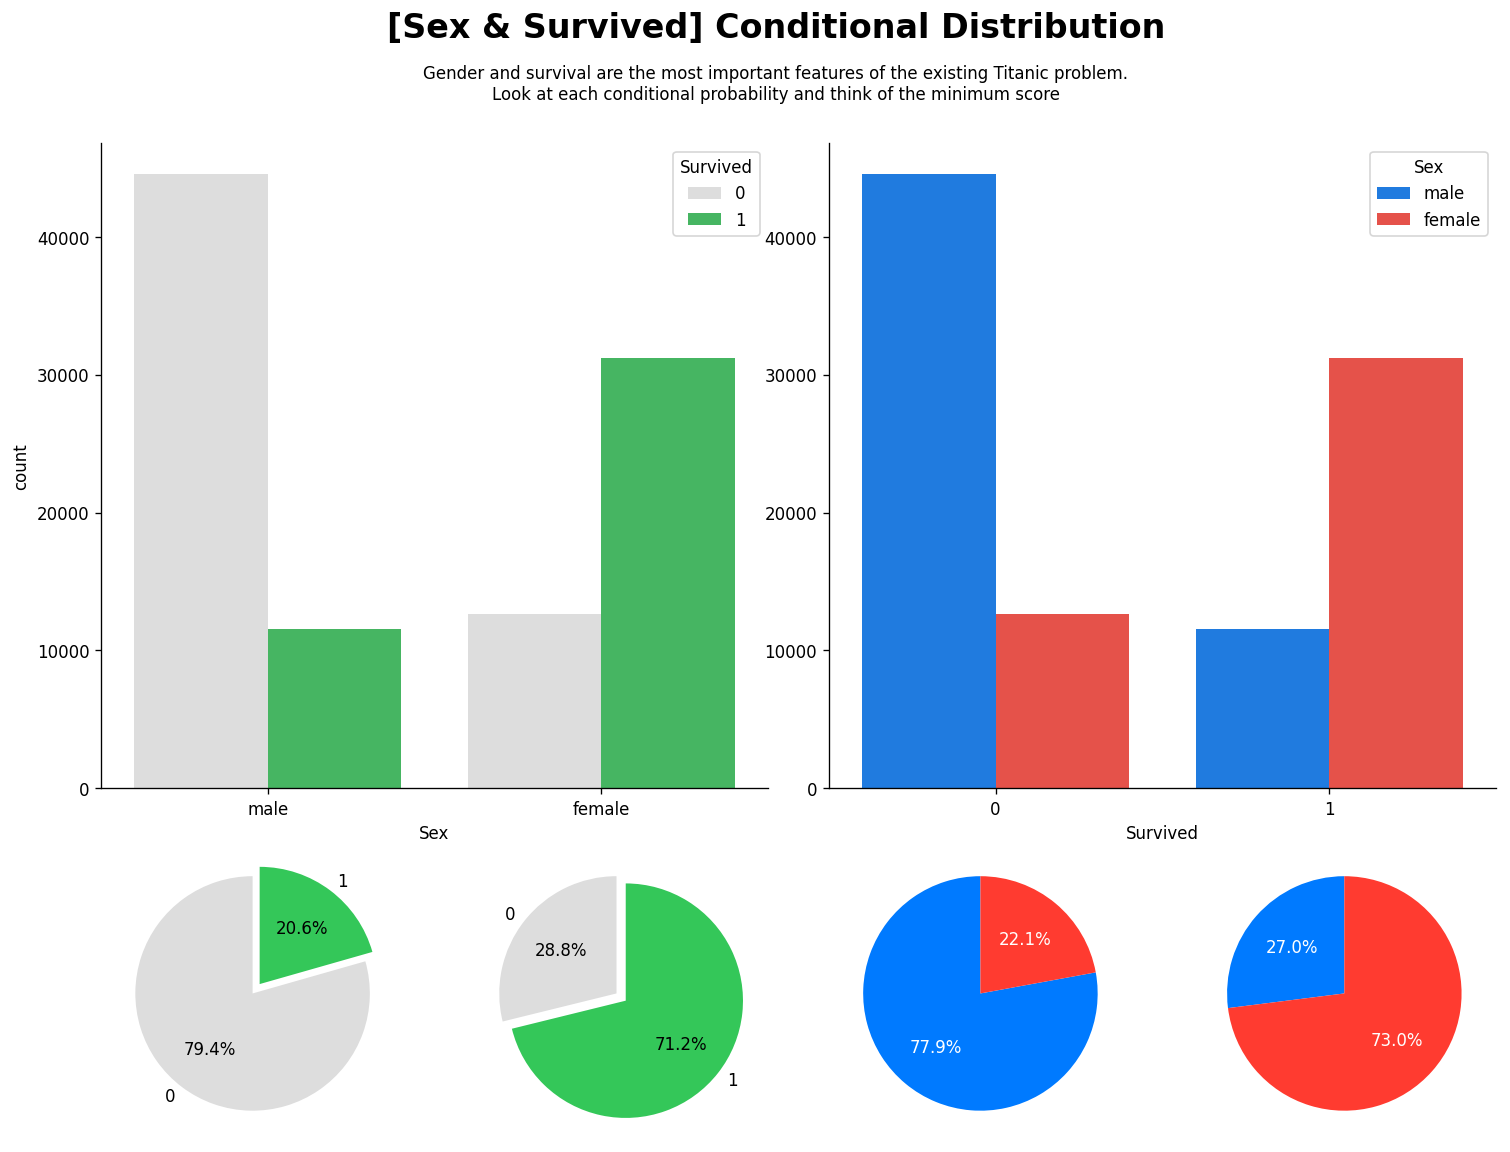

In [122]:
fig = plt.figure(figsize=(15, 11))

gs = fig.add_gridspec(3, 4) # row size * column size 형태의 1차원 어레이, subplot 사이즈 조절. 한 화면을 3 x 4 형태로 분할한다고 생각하면 됨.




ax_sex_survived = fig.add_subplot(gs[:2,:2])
sns.countplot(x='Sex',hue='Survived', data=train, ax=ax_sex_survived, 
              palette=survived_palette)

ax_survived_sex = fig.add_subplot(gs[:2,2:4], sharey=ax_sex_survived)
sns.countplot(x='Survived',hue='Sex', data=train, ax=ax_survived_sex,
              palette=sex_palette
             )

# ax_survived_sex.set_yticks([])
ax_survived_sex.set_ylabel('')

ax_pie_male = fig.add_subplot(gs[2, 0])
ax_pie_female = fig.add_subplot(gs[2, 1])
ax_pie_notsurvived = fig.add_subplot(gs[2, 2])
ax_pie_survived = fig.add_subplot(gs[2, 3])

# Sex
male = train[train['Sex']=='male']['Survived'].value_counts().sort_index()
ax_pie_male.pie(male, labels=male.index, autopct='%1.1f%%',explode = (0, 0.1), startangle=90,
               colors=survived_palette
               )


female = train[train['Sex']=='female']['Survived'].value_counts().sort_index()
ax_pie_female.pie(female, labels=female.index, autopct='%1.1f%%',explode = (0, 0.1), startangle=90,
                colors=survived_palette
                 )

# Survived
notsurvived = train[train['Survived']==0]['Sex'].value_counts()[['male', 'female']]
ax_pie_notsurvived.pie(notsurvived, labels=notsurvived.index, autopct='%1.1f%%',startangle=90,
                      colors=sex_palette, textprops={'color':"w"}
                      )

survived = train[train['Survived']==1]['Sex'].value_counts()[['male', 'female']]
ax_pie_survived.pie(survived, labels=survived.index, autopct='%1.1f%%', startangle=90,
                    colors=sex_palette, textprops={'color':"w"}
                   )

fig.suptitle('[Sex & Survived] Conditional Distribution', fontweight='bold', fontsize=20)
fig.text(s='''Gender and survival are the most important features of the existing Titanic problem.\nLook at each conditional probability and think of the minimum score''', 
         x=0.5, y= 0.94, ha='center', va='top')

plt.show()

In [123]:
def age_band(num):
    for i in range(1, 100):
        if num < 10*i : return f'{(i-1) * 10} ~ {i*10}'
        
        
train['Age band'] = train['Age'].apply(age_band)
titanic_age = train[['Age band', 'Survived']].groupby('Age band')['Survived'].value_counts().sort_index().unstack()
titanic_age['Survival rate'] = titanic_age[1] / (titanic_age[0] + titanic_age[1]) * 100
age_band = train['Age band'].value_counts().sort_index()
print(age_band)

0 ~ 10      8611
10 ~ 20     4999
20 ~ 30    20283
30 ~ 40    15783
40 ~ 50    15677
50 ~ 60    18134
60 ~ 70    10819
70 ~ 80     2318
80 ~ 90       84
Name: Age band, dtype: int64


In [124]:
pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.1)


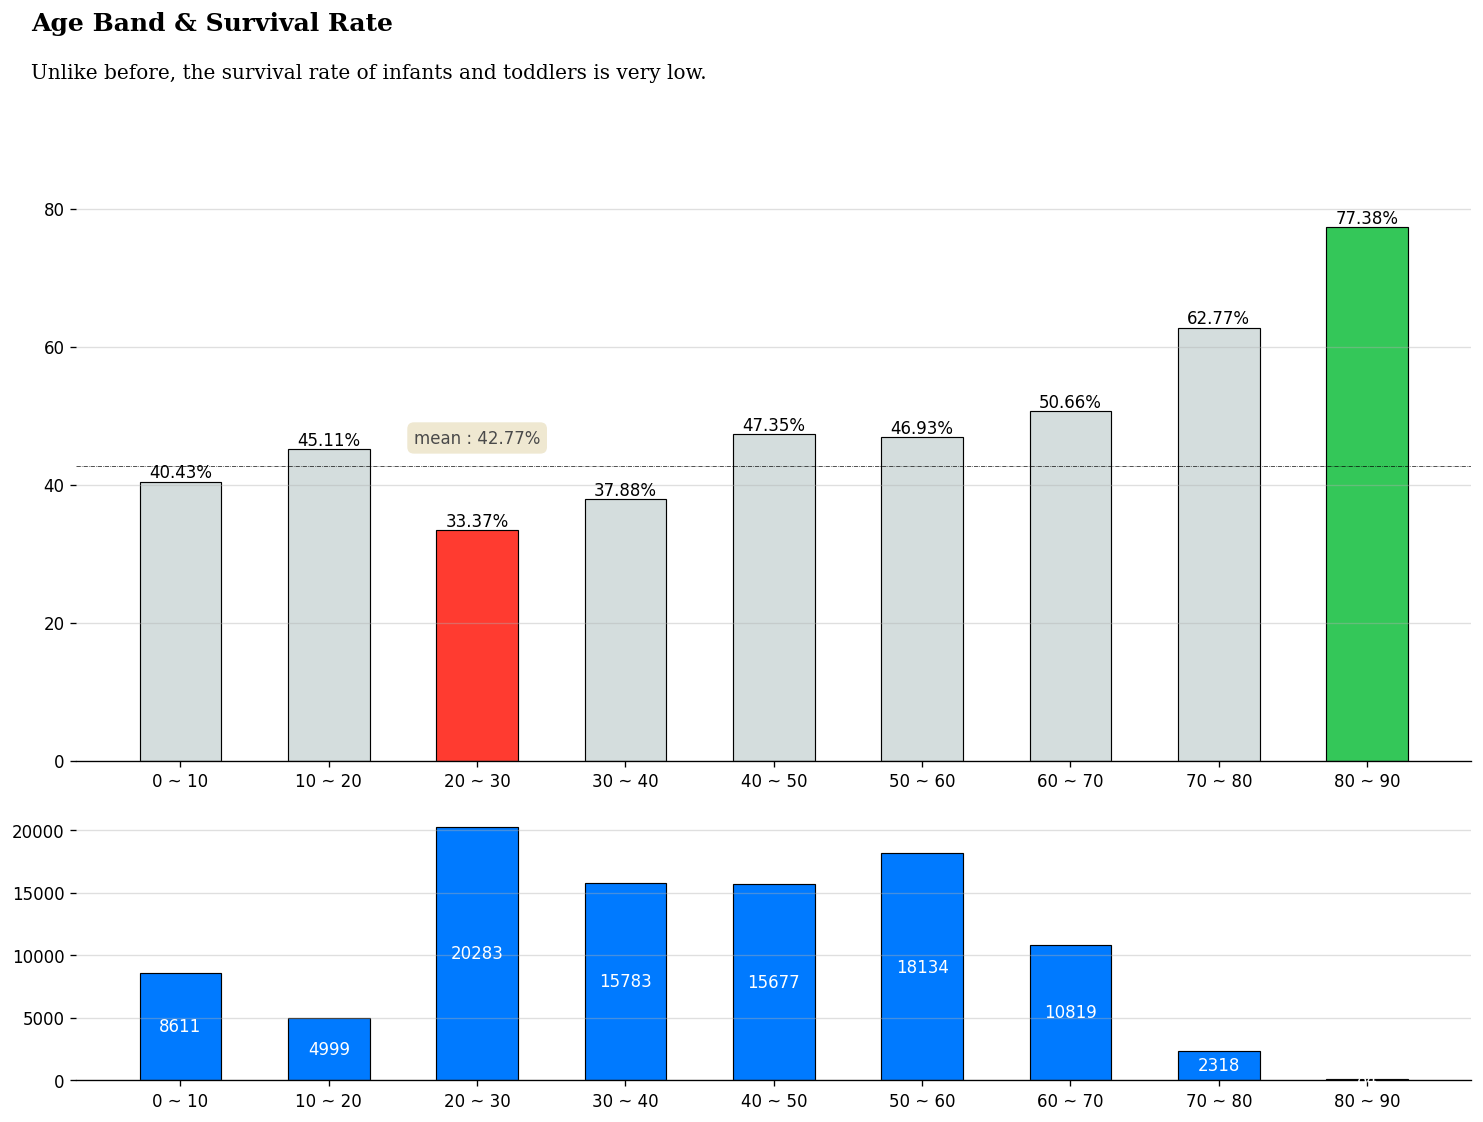

In [125]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:-1,:])

color_map = ['#d4dddd' for _ in range(9)]
color_map[2] = light_palette[3]
color_map[8] = light_palette[2]


bars = ax.bar(titanic_age['Survival rate'].index, titanic_age['Survival rate'], 
       color=color_map, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.bar_label(bars, fmt='%.2f%%')


# mean line + annotation
mean = train['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='dashdot')
ax.annotate(f"mean : {mean :.4}%", 
            xy=('20 ~ 30', mean + 4),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    


ax.set_yticks(np.arange(0, 81, 20))
ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.set_ylim(0, 85)


ax_bottom = fig.add_subplot(gs[-1,:])
bars = ax_bottom.bar(age_band.index, age_band, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax_bottom.spines[["top","right","left"]].set_visible(False)
ax_bottom.bar_label(bars, fmt='%d', label_type='center', color='white')
ax_bottom.grid(axis='y', linestyle='-', alpha=0.4)

# Title & Subtitle    
fig.text(0.1, 1, 'Age Band & Survival Rate', fontsize=15, fontweight='bold', fontfamily='serif', ha='left')
fig.text(0.1, 0.96, 'Unlike before, the survival rate of infants and toddlers is very low.', fontsize=12, fontweight='light', fontfamily='serif', ha='left')

plt.show()

In [126]:
def get_category_fare_age(fare_age):
    cat = ''
    if fare_age <= -1: cat = 'Unknown'
    elif fare_age <= 5000: cat = 'Low'
    elif fare_age <= 10000: cat = 'Middle '
    elif fare_age <= 20000: cat = 'High'
    elif fare_age <= 40000: cat = 'Very High'
    else : cat = 'Ultra High'
    
    return cat

In [127]:
train['Age'].fillna(train['Age'].mean(), inplace=True)
train['Fare'].fillna(train['Fare'].mean(), inplace=True)

train['Fare*Age'] = train['Age'] * train['Fare']
train['Fare*Age'] = train['Fare*Age'].apply(lambda x : get_category_fare_age(x))
titanic_fare_age = train[['Fare*Age', 'Survived']].groupby('Fare*Age')['Survived'].value_counts().sort_index().unstack()
titanic_fare_age['Survival rate'] = titanic_fare_age[1] / (titanic_fare_age[0] + titanic_fare_age[1]) * 100

Fare_Age = train['Fare*Age'].value_counts().sort_index()

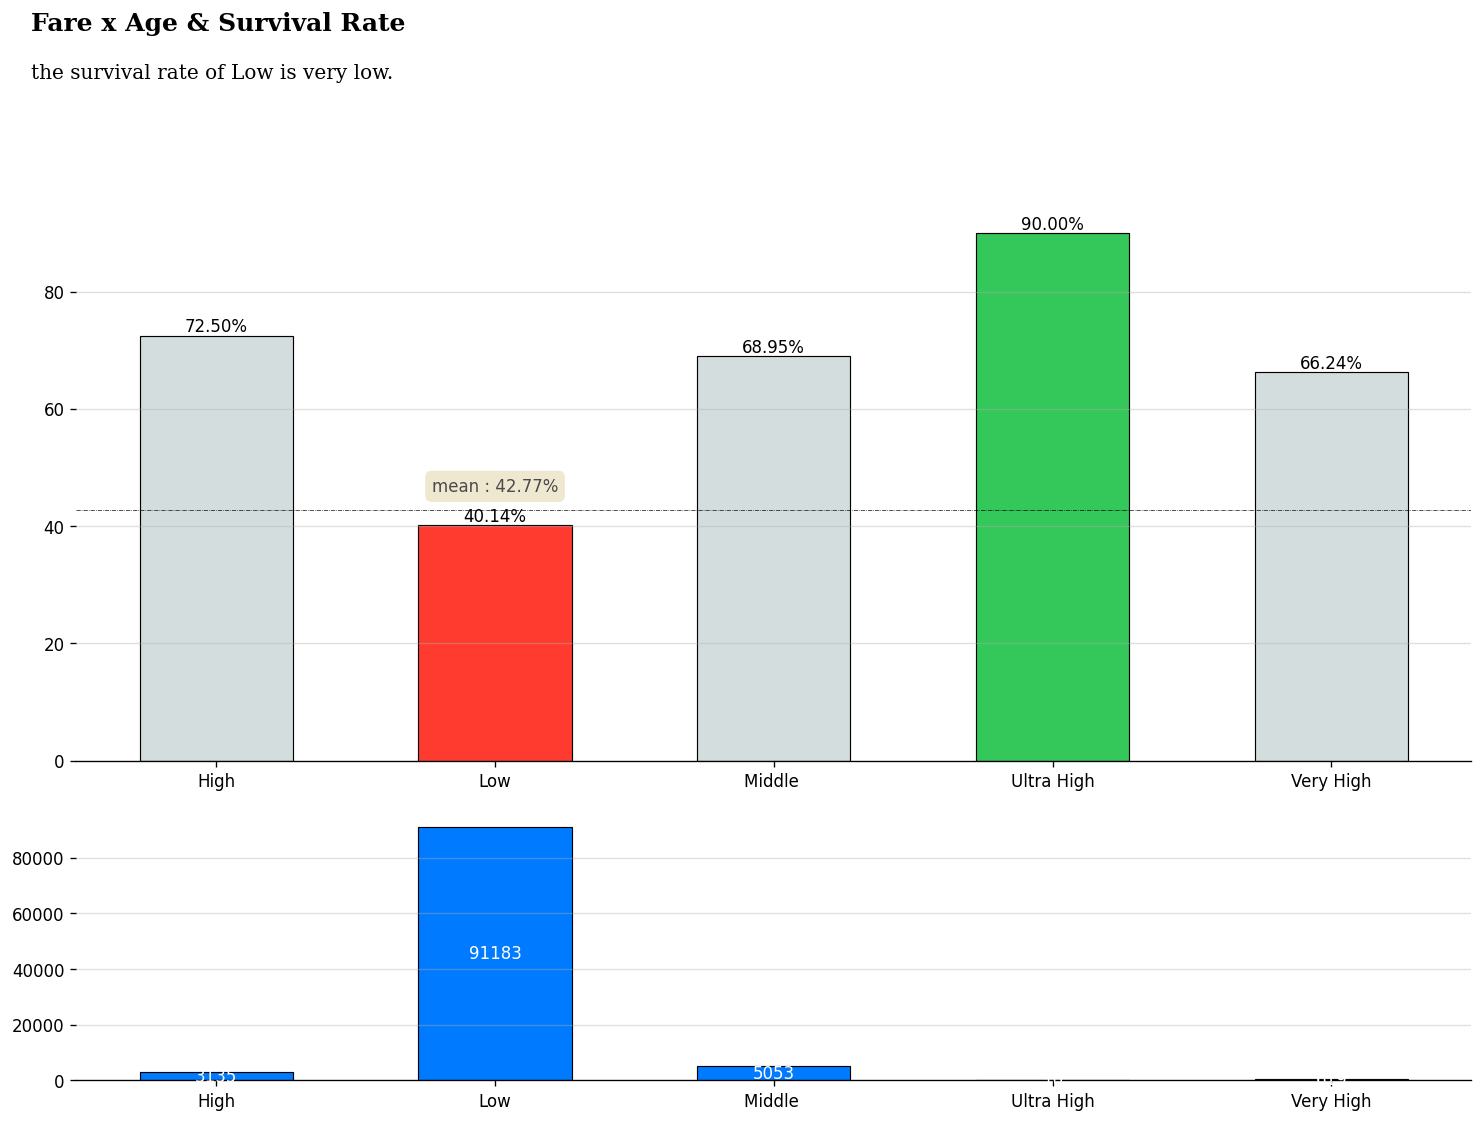

In [128]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:-1,:])

color_map = ['#d4dddd' for _ in range(5)]
color_map[1] = light_palette[3]
color_map[3] = light_palette[2]


bars = ax.bar(titanic_fare_age['Survival rate'].index, titanic_fare_age['Survival rate'], 
       color=color_map, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax.spines[["top","right","left"]].set_visible(False)
ax.bar_label(bars, fmt='%.2f%%')


# mean line + annotation
mean = train['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='dashdot')
ax.annotate(f"mean : {mean :.4}%", 
            xy=('Low', mean + 4),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    



ax.set_yticks(np.arange(0, 100, 20))
ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.set_ylim(0, 100)


ax_bottom = fig.add_subplot(gs[-1,:])
bars = ax_bottom.bar(Fare_Age.index, Fare_Age, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax_bottom.spines[["top","right","left"]].set_visible(False)
ax_bottom.bar_label(bars, fmt='%d', label_type='center', color='white')
ax_bottom.grid(axis='y', linestyle='-', alpha=0.4)

# Title & Subtitle    
fig.text(0.1, 1, 'Fare x Age & Survival Rate', fontsize=15, fontweight='bold', fontfamily='serif', ha='left')
fig.text(0.1, 0.96, 'the survival rate of Low is very low.', fontsize=12, fontweight='light', fontfamily='serif', ha='left')

plt.show()

In [129]:
num_columns = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [130]:
def show_hist_by_target(df, columns):
    cond_1 = (df['Survived'] == 1)
    cond_0 = (df['Survived'] == 0)

    for column in columns:
        fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
        sns.violinplot(x='Survived', y=column, data=df, ax=axs[0][0])
        sns.distplot(df[cond_1][column], label='1', color='red', ax=axs[0][1])
        sns.distplot(df[cond_0][column], label='0', color='blue', ax=axs[0][1])  

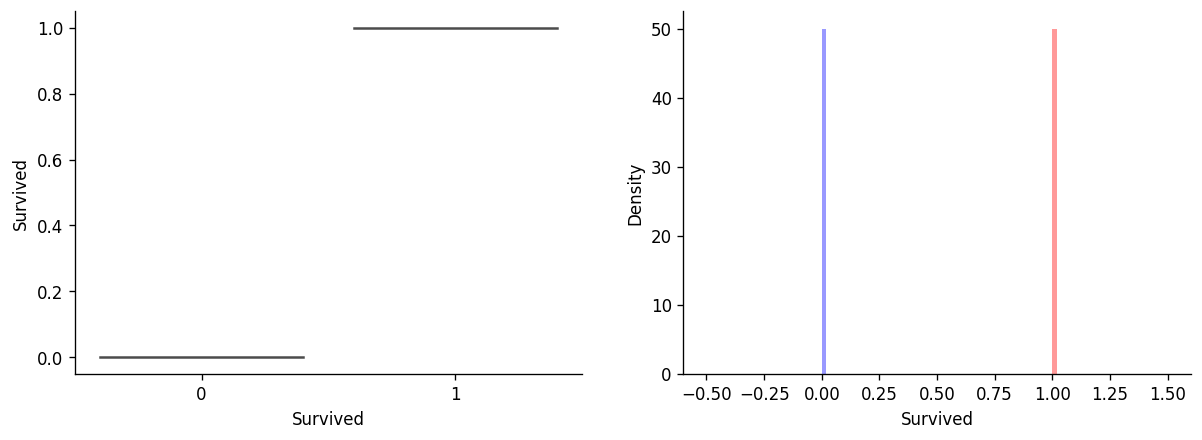

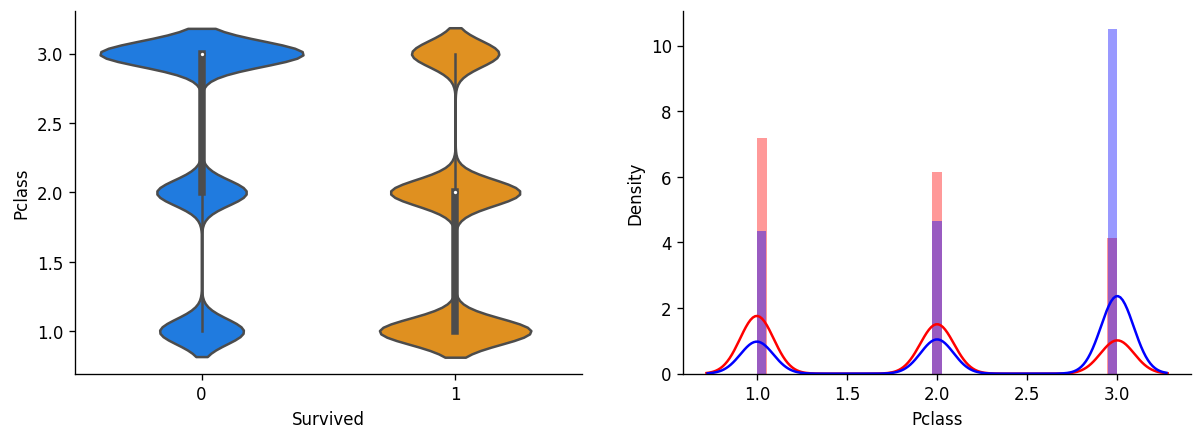

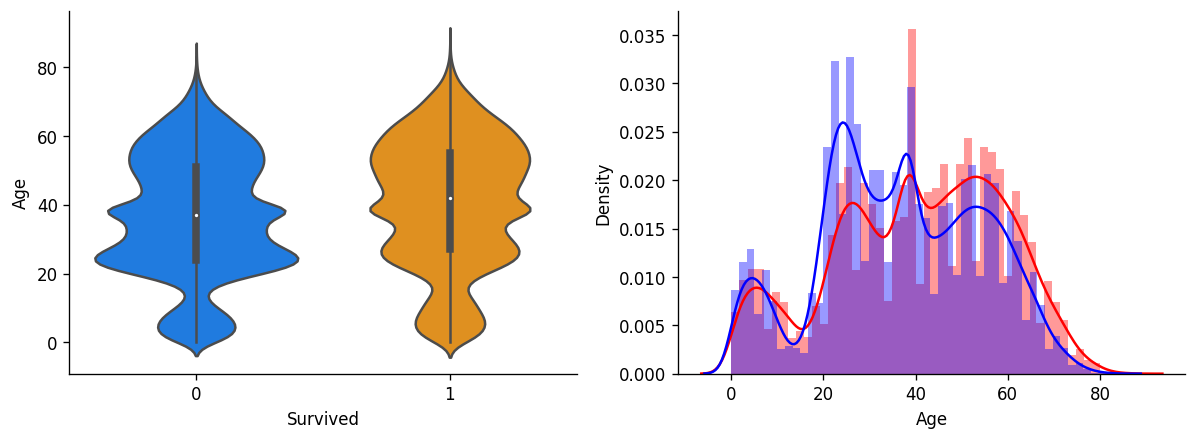

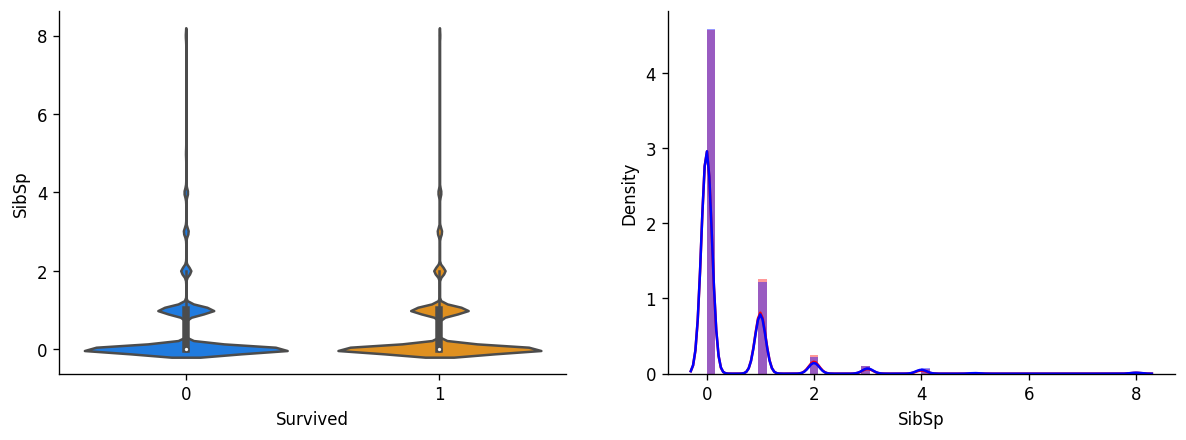

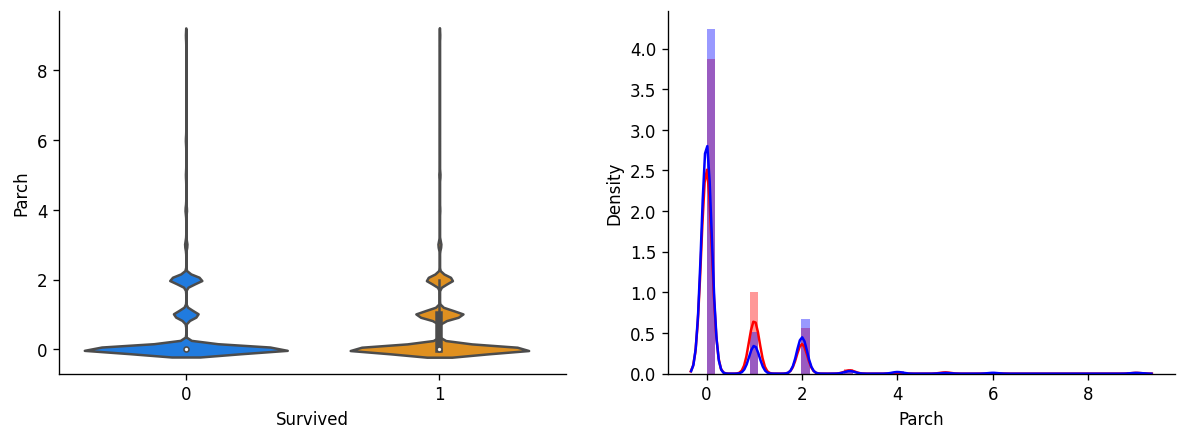

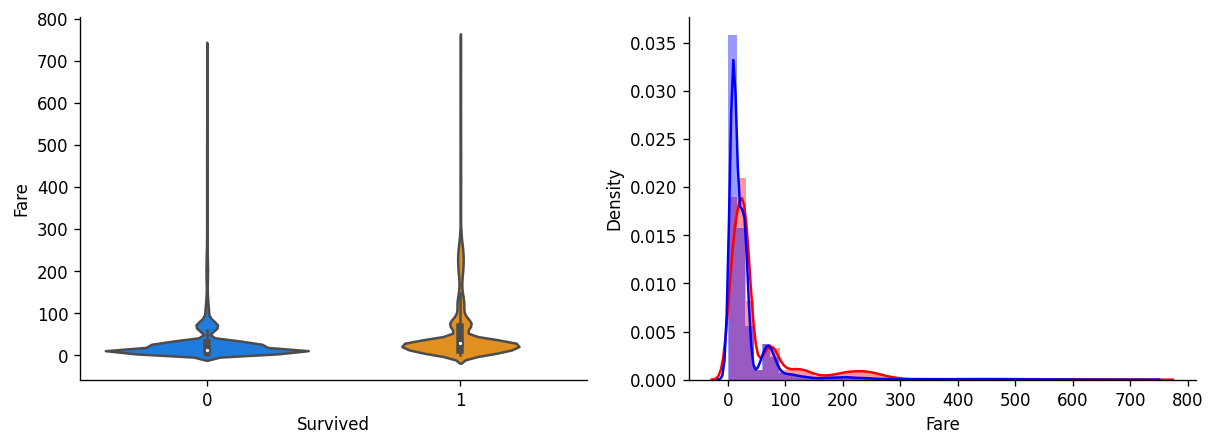

In [131]:
show_hist_by_target(train, num_columns)

In [132]:

def get_category_age(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

In [133]:
train['Age'].fillna(train['Age'].mean(), inplace=True)
train['Age'] = train['Age'].apply(lambda x : get_category_age(x))

In [134]:
def get_category_fare(fare):
    cat = ''
    if fare <= -1: cat = 'Unknown'
    elif fare <= 40: cat = 'Lower Class'
    elif fare < 150: cat = 'Middle Class'
    elif fare <= 300: cat = 'Upper Middle Class'
    elif fare <= 400: cat = 'Upper Class'
    elif fare <= 600: cat = 'Rich'
    elif fare <= 800: cat = 'Super Rich'
    else : cat = 'Crazy Rich'
    
    return cat

1등실 : (응접실이 딸린 스위트 룸) $4,350

1등실 : (침실칸) $150

2등실 : 60$

3등실 : 15~40$

In [135]:
train['Fare'].fillna(train['Fare'].mean(), inplace=True)
train['Fare'] = train['Fare'].apply(lambda x : get_category_fare(x))

In [136]:
def get_category_name(name):
    cat = ''
    if name <= -1: cat = 'Unknown'
    elif name <= 2: cat = 'highly rare'
    elif name <= 5: cat = 'rare'
    elif name <= 50: cat = 'slightly common'
    elif name <= 500: cat = 'common'
    elif name <= 1000: cat = 'moderately common'
    else : cat = 'highly common'
    
    return cat

In [137]:
train['FamName'] = train['Name'].str.extract('([A-Za-z]+)\,', expand=False)
FamName = train['FamName'].value_counts()
FamName = FamName.apply(lambda x : get_category_name(x))
train['FamName'] = train['FamName'].apply(lambda x: FamName[x])
print(train['FamName'].value_counts())

slightly common      33623
common               25255
highly rare          19463
rare                 16949
moderately common     3548
highly common         1162
Name: FamName, dtype: int64


In [138]:
def get_category_family(family):
    cat = ''
    if family <= -1: cat = 'Unknown'
    elif family <= 1: cat = 'Alone'
    elif family <= 2: cat = 'Couple'
    elif family <= 5: cat = 'Small'
    elif family <= 8: cat = 'Medium'
    elif family <= 12: cat = 'Big'
    else : cat = 'Very Big'
    
    return cat

In [139]:
train['FamSize'] = train['SibSp'] + train['Parch'] + 1
train['FamSize'] = train['FamSize'].apply(lambda x : get_category_family(x))

In [140]:
train['Ticket'] = train['Ticket'].apply(lambda x: x[0] if type(x) == str else 'Missing')

In [141]:
train['Cabin'] = train['Cabin'].apply(lambda x: x[0] if type(x) == str else 'Missing')

In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   PassengerId  100000 non-null  int64 
 1   Survived     100000 non-null  int64 
 2   Pclass       100000 non-null  int64 
 3   Name         100000 non-null  object
 4   Sex          100000 non-null  object
 5   Age          100000 non-null  object
 6   SibSp        100000 non-null  int64 
 7   Parch        100000 non-null  int64 
 8   Ticket       100000 non-null  object
 9   Fare         100000 non-null  object
 10  Cabin        100000 non-null  object
 11  Embarked     99750 non-null   object
 12  Age band     96708 non-null   object
 13  Fare*Age     100000 non-null  object
 14  FamName      100000 non-null  object
 15  FamSize      100000 non-null  object
dtypes: int64(5), object(11)
memory usage: 12.2+ MB


In [143]:
train.dtypes[train.dtypes == 'object'].index.tolist()

['Name',
 'Sex',
 'Age',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Age band',
 'Fare*Age',
 'FamName',
 'FamSize']

In [144]:
object_columns = ['Age','FamName','FamSize','Cabin','Ticket','Fare']

column name: Age
column name: FamName
column name: FamSize
column name: Cabin
column name: Ticket
column name: Fare


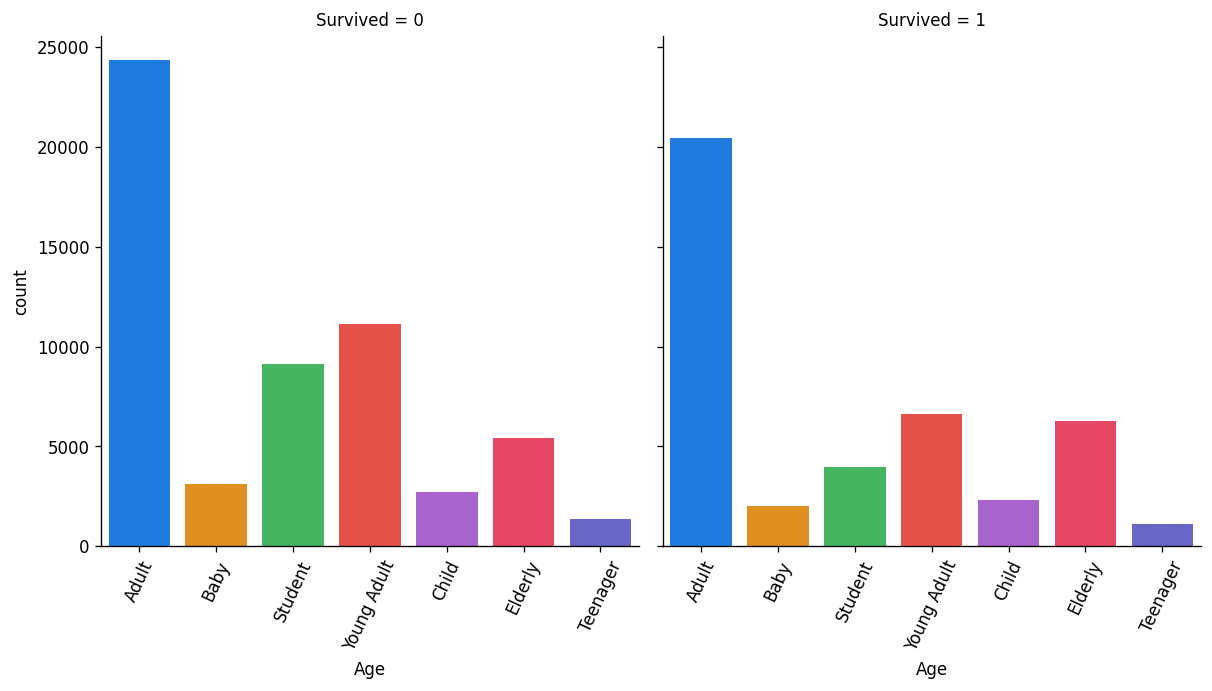

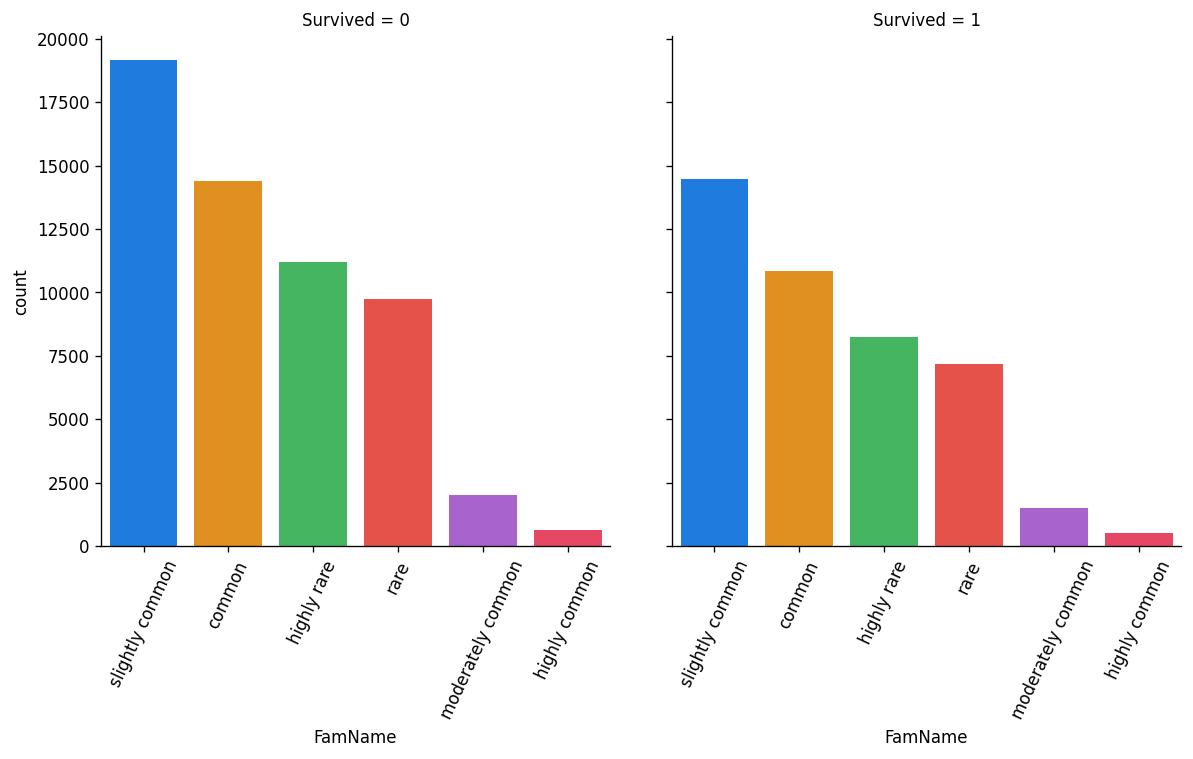

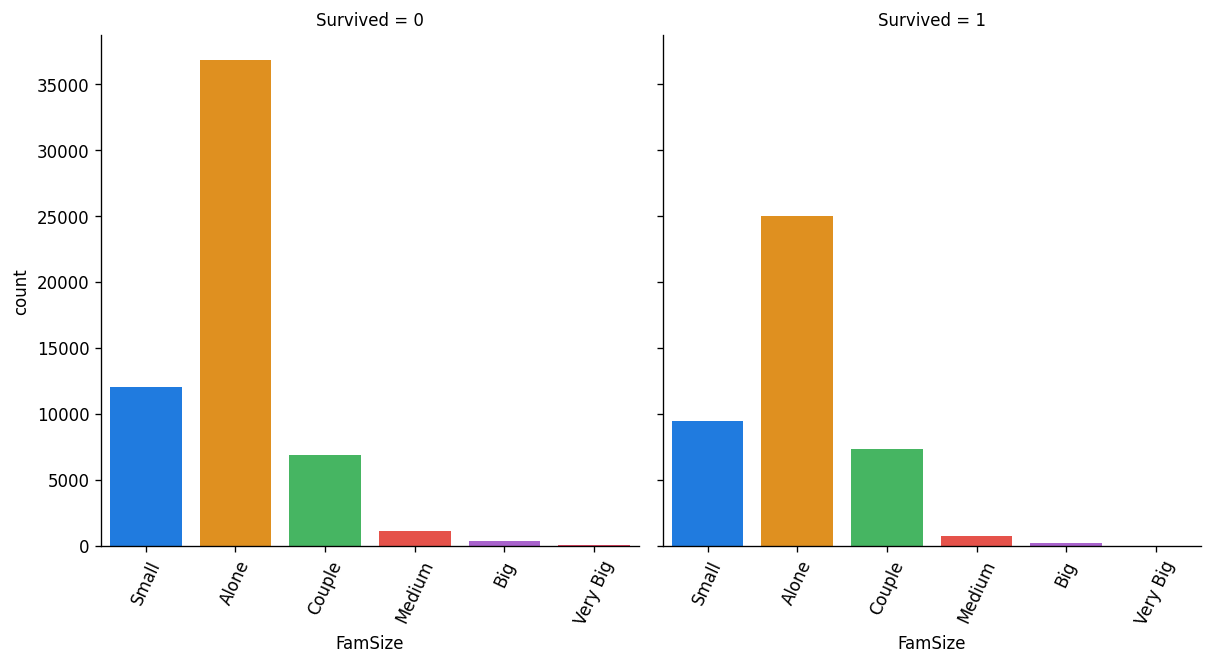

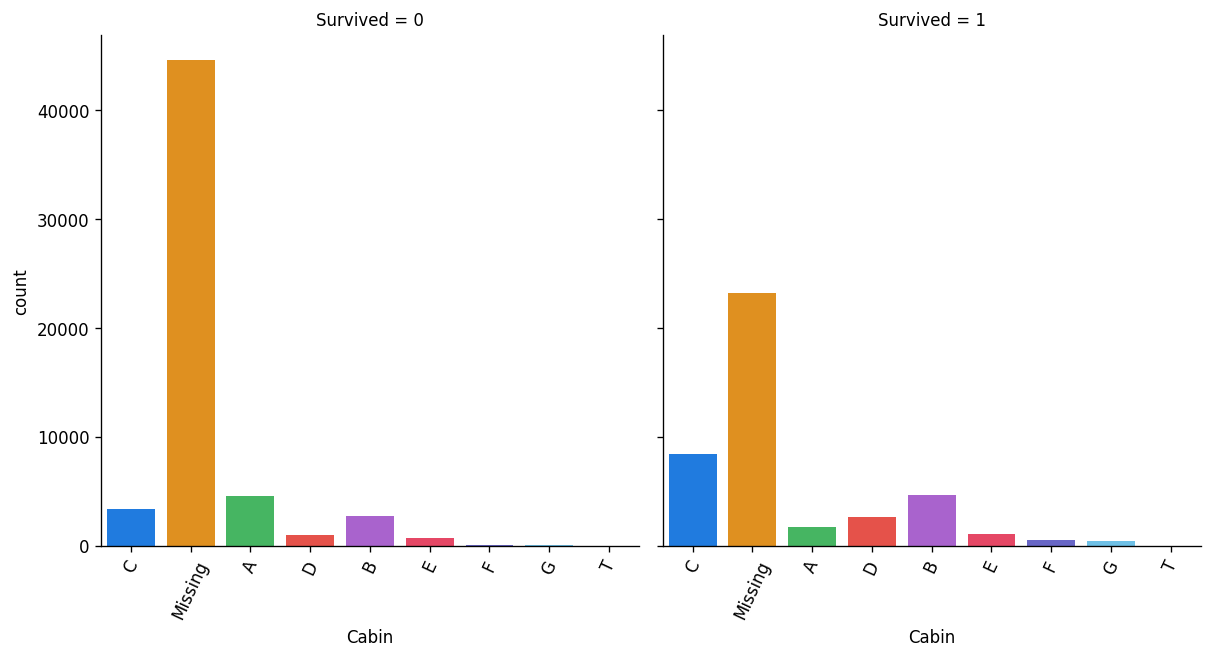

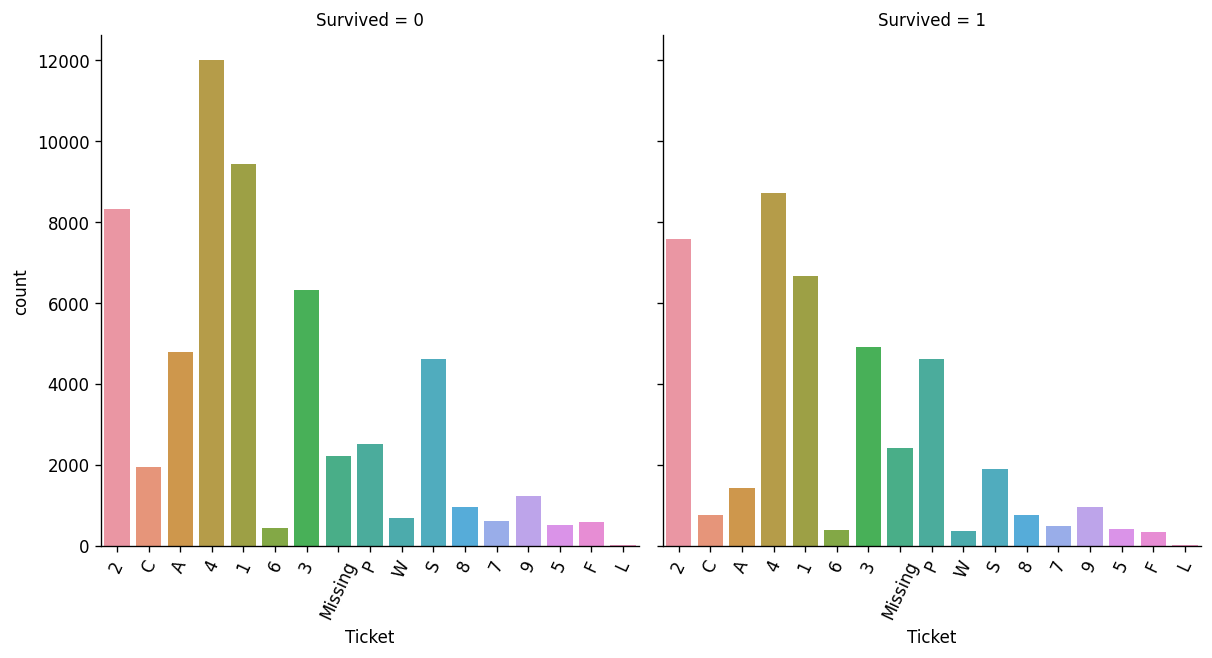

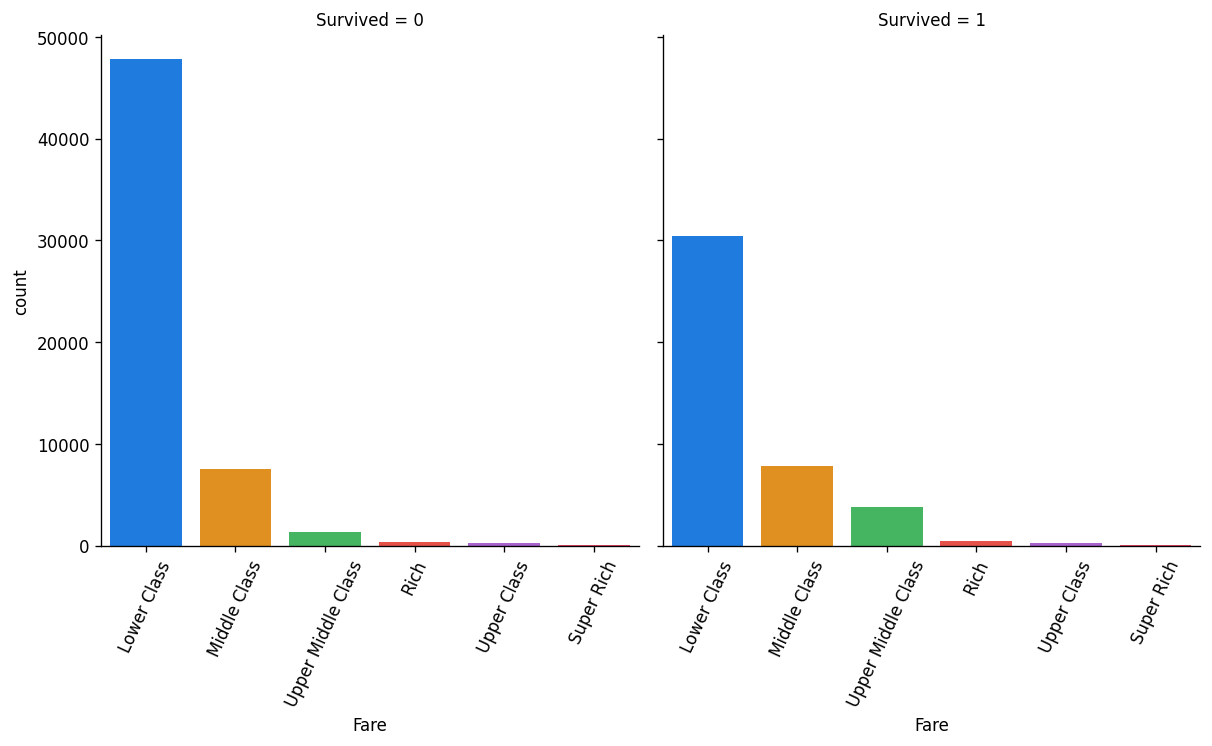

In [145]:
def show_category_by_target(df,columns):
    for column in columns:
        print('column name:',column)
        chart = sns.catplot(x=column, col='Survived', data=df, kind='count')
        chart.set_xticklabels(rotation=65)

show_category_by_target(train, object_columns)

In [146]:
train = pd.read_csv('./train.csv')
test= pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')

train.shape, test.shape, sample_submission.shape

((100000, 12), (100000, 11), (100000, 2))

In [147]:
print(train['Embarked'].value_counts())

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64


In [148]:
Survived_0 = (train['Survived'] == 0)
Survived_1 = (train['Survived'] == 1)

# Embarked에 따른 사망 비율
print('_'*20)
print('Embarked에 따른 사망 비율') 
print('S :',train[Survived_0 & (train['Embarked'] == 'S')]['Embarked'].count() / train[Survived_0].shape[0])
print('C :',train[Survived_0 & (train['Embarked'] == 'C')]['Embarked'].count() / train[Survived_0].shape[0])
print('Q :',train[Survived_0 & (train['Embarked'] == 'Q')]['Embarked'].count() / train[Survived_0].shape[0])

# Embarked에 따른 사망 비율
print('_'*20)
print('Embarked에 따른 생존 비율') 
print('S :',train[Survived_0 & (train['Embarked'] == 'S')]['Embarked'].count() / train[Survived_0].shape[0])
print('C :',train[Survived_0 & (train['Embarked'] == 'C')]['Embarked'].count() / train[Survived_0].shape[0])
print('Q :',train[Survived_0 & (train['Embarked'] == 'Q')]['Embarked'].count() / train[Survived_0].shape[0])


# S : 사망 비율 / 생존 비율
print('_'*20)
print('S : 사망 비율 / 생존 비율')
print('사망 비율 : ',train[Survived_0 & (train['Embarked'] == 'S')]['Embarked'].count() / train[train['Embarked'] == 'S'].shape[0])
print('생존 비율 : ',train[Survived_1 & (train['Embarked'] == 'S')]['Embarked'].count() / train[train['Embarked'] == 'S'].shape[0])

# C : 사망 비율 / 생존 비율
print('_'*20)
print('C : 사망 비율 / 생존 비율')
print('사망 비율 : ',train[Survived_0 & (train['Embarked'] == 'C')]['Embarked'].count() / train[train['Embarked'] == 'C'].shape[0])
print('생존 비율 : ',train[Survived_1 & (train['Embarked'] == 'C')]['Embarked'].count() / train[train['Embarked'] == 'C'].shape[0])

# Q : 사망 비율 / 생존 비율
print('_'*20)
print(' Q : 사망 비율 / 생존 비율')
print('사망 비율 : ',train[Survived_0 & (train['Embarked'] == 'Q')]['Embarked'].count() / train[train['Embarked'] == 'Q'].shape[0])
print('생존 비율 : ',train[Survived_1 & (train['Embarked'] == 'Q')]['Embarked'].count() / train[train['Embarked'] == 'Q'].shape[0])

____________________
Embarked에 따른 사망 비율
S : 0.8631391325621222
C : 0.09642470205850487
Q : 0.038199419844126795
____________________
Embarked에 따른 생존 비율
S : 0.8631391325621222
C : 0.09642470205850487
Q : 0.038199419844126795
____________________
S : 사망 비율 / 생존 비율
사망 비율 :  0.6847059149697112
생존 비율 :  0.3152940850302888
____________________
C : 사망 비율 / 생존 비율
사망 비율 :  0.24870419615089917
생존 비율 :  0.7512958038491008
____________________
 Q : 사망 비율 / 생존 비율
사망 비율 :  0.403023598820059
생존 비율 :  0.596976401179941


In [149]:
# Embarked가 S일 경우 Fare의 평균값
print(train[train['Embarked'] == 'S']['Fare'].mean())
# Embarked가 C일 경우 Fare의 평균값 
print(train[train['Embarked'] == 'C']['Fare'].mean())
# Embarked가 Q일 경우 Fare의 평균값
print(train[train['Embarked'] == 'Q']['Fare'].mean())

33.20000777270393
71.54907285366082
73.38514771048735


Southampton에서 승선한 승객들이 대체로 탑승 요금이 적다는 부분에서 이들의 대부분이 3등실에 탔을 것이라고 예측할 수 있다.

In [150]:
titanic_embarked = train[['Embarked', 'Survived']].groupby('Embarked')['Survived'].value_counts().sort_index().unstack()
titanic_embarked['Survival rate'] = titanic_embarked[1] / (titanic_embarked[0] + titanic_embarked[1]) * 100

embarked = train['Embarked'].value_counts().sort_index()

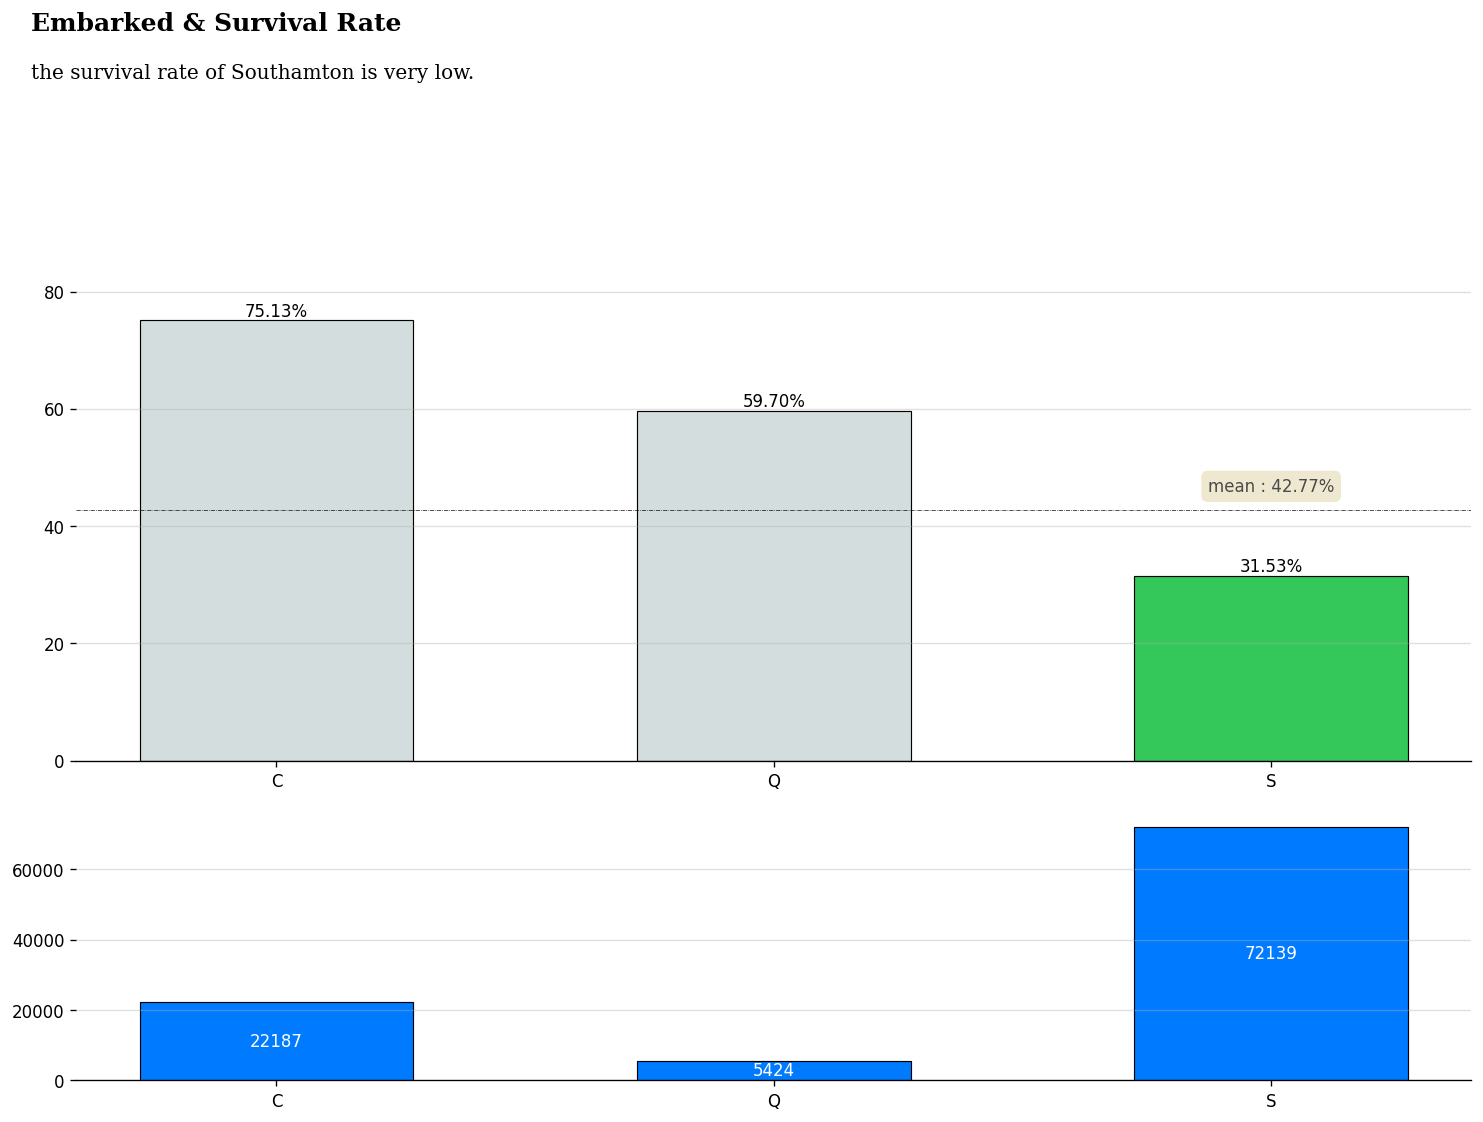

In [151]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:-1,:])

color_map = ['#d4dddd' for _ in range(3)]
color_map[2] = light_palette[2]


bars = ax.bar(titanic_embarked['Survival rate'].index, titanic_embarked['Survival rate'], 
       color=color_map, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax.spines[["top","right","left"]].set_visible(False)
ax.bar_label(bars, fmt='%.2f%%')


# mean line + annotation
mean = train['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='dashdot')
ax.annotate(f"mean : {mean :.4}%", 
            xy=('S', mean + 4),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    



ax.set_yticks(np.arange(0, 100, 20))
ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.set_ylim(0, 100)


ax_bottom = fig.add_subplot(gs[-1,:])
bars = ax_bottom.bar(embarked.index, embarked, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax_bottom.spines[["top","right","left"]].set_visible(False)
ax_bottom.bar_label(bars, fmt='%d', label_type='center', color='white')
ax_bottom.grid(axis='y', linestyle='-', alpha=0.4)

# Title & Subtitle    
fig.text(0.1, 1, 'Embarked & Survival Rate', fontsize=15, fontweight='bold', fontfamily='serif', ha='left')
fig.text(0.1, 0.96, 'the survival rate of Southamton is very low.', fontsize=12, fontweight='light', fontfamily='serif', ha='left')

plt.show()

<a id='handling_missing_values'></a>
### (3) Handling Missing Values
- Let's fill with some value in each column.
> *Important Note:* This idea is from [TPS Apr 2021 LightGBM CV](https://www.kaggle.com/jmargni/tps-apr-2021-lightgbm-cv). Thank you. 


In [152]:
temp = pd.concat([train, test])

In [153]:
temp['Fare'] = temp['Fare'].fillna(temp['Fare'].mean())
temp['Age'] = temp['Age'].fillna(temp['Age'].mean())
temp['Embarked'] = temp['Embarked'].fillna('N')
temp['Cabin'] = temp['Cabin'].str[:1]
temp['FirstName'] = temp['Name'].apply(lambda x:x.split(', ')[0])
temp['n'] = 1
gb = temp.groupby('FirstName')
df_names = gb['n'].sum()
temp['SameFirstName'] = temp['FirstName'].apply(lambda x:df_names[x])
temp['SameFirstName'] = temp['SameFirstName'].apply(lambda x:-1 if x>10 else x)
temp = temp.drop(['n','FirstName'],axis=1)

temp['Name'] = temp['Name'].map(lambda x: str(x).split(',')[0])
temp['Ticket'] = temp['Ticket'].map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')
temp['Cabin'] = temp['Cabin'].map(lambda x: str(x)[0].strip())

temp['Family_Size'] = temp['SibSp'] + temp['Parch'] + 1
temp['Alone?'] = False
temp.loc[temp['Family_Size'] == 1, 'Alone?'] = True
temp['Cabin?'] = temp['Cabin'].apply(lambda x: False if str(x[:1]) == 'n' else True)
temp['Age*Fare'] = temp['Age'] * temp['Fare']
temp['Age/Fare'] = temp['Age'] / temp['Fare']

In [154]:
temp.tail(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SameFirstName,Family_Size,Alone?,Cabin?,Age*Fare,Age/Fare
99995,199995,NaN,3,Cash,female,27.0,0,0,X,10.12,n,Q,-1,1,True,False,273.24,2.667984
99996,199996,NaN,1,Brown,male,59.0,1,0,X,68.31,n,S,-1,2,False,False,4030.29,0.863710
99997,199997,NaN,3,Lightfoot,male,47.0,0,0,X,10.87,n,S,8,1,True,False,510.89,4.323827
99998,199998,NaN,1,Jacobsen,female,49.0,1,2,PC,29.68,B,C,-1,4,False,True,1454.32,1.650943
99999,199999,NaN,1,Fishback,female,41.0,0,2,PC,195.41,E,C,3,3,False,True,8011.81,0.209815


In [155]:
temp.select_dtypes(exclude=['float64','int64','bool']).columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket',
       'Cabin', 'Embarked', 'SameFirstName', 'Family_Size'],
      dtype='object')

In [156]:
np.where((temp.dtypes != 'float64')&(temp.dtypes != 'int64')&(temp.dtypes != 'bool'))[0].tolist()

[3, 4, 8, 10, 11]

In [157]:
categorical_feature = np.where((temp.dtypes != 'float64')&(temp.dtypes != 'int64')&(temp.dtypes != 'bool'))[0].tolist()
categorical_feature_columns = temp.select_dtypes(exclude=['float64','int64','bool']).columns

<a id='feature_encoding'></a>
### (4) Feature Encoding
- Let's check each column's data type

- Dataset will be divided into two groups - categorical variables and numerical variables


In [158]:
label = LabelEncoder()
for column in categorical_feature_columns:
    label.fit(temp[column])
    temp[column] = label.transform(temp[column])

> Important note: When conducting feature encoding, Newbies must understand difference between ordinal encoding, label encoding, and one-hot encoding. See. https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/


<a id='split_data'></a>
### (5) Split Data
- Based on Feature Engineering, the final task is to re-split all data into independent variables and dependent variables. 





In [159]:
train_df = temp[:100000]
test_df = temp[100000:]
train_df.shape, test_df.shape

((100000, 18), (100000, 18))

In [160]:
test_df = test_df.drop(['Survived'],axis=1)
X = train_df.drop(['Survived'],axis=1)
y = train_df['Survived']

In [161]:
X.shape, y.shape

((100000, 17), (100000,))

<a id="limitation"></a>
### (6) Limitation
- What I missed here is not to create new variable so-called wealthy class and others, yet. My assumption is wealthy people were more survived than other group. This will be compared baseline model with the more upgraded model, reflecting new feature. If some readers get this idea, then please implement it. Hope to see a better model. 

<a id="scikit_learn"></a>
## Scikit Learn
- Let's make simple model based on Scikit Learn Framework.
- URL: https://scikit-learn.org/stable/

![](https://scikit-learn.org/stable/_images/scikit-learn-logo-notext.png)

<a id="data_split"></a>
### (1) Data Split
- We know test data exists as final testset, so we create validation set from sklearn module. 
- We will use [Stratified Sampling](https://medium.com/@411.codebrain/train-test-split-vs-stratifiedshufflesplit-374c3dbdcc36). 

In [162]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [163]:
!pip install bayesian-optimization==1.1.0

In [194]:
from bayes_opt import BayesianOptimization

In [195]:
bayes_x,bayes_x_test,bayes_y,bayes_y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [197]:
bayes_params = {
    'num_leaves': (24, 45),
    'colsample_bytree':(0.5, 1), 
    'subsample': (0.5, 1),
    'max_depth': (4, 12),
    'reg_alpha': (0, 0.5),
    'reg_lambda': (0, 0.5), 
    'min_split_gain': (0.001, 0.1),
    'min_child_weight':(5, 50)
}

In [198]:
def lgb_roc_eval(num_leaves, colsample_bytree, subsample, max_depth, reg_alpha, reg_lambda, min_split_gain, min_child_weight):
    
    params = {
        "n_estimator":200, "learning_rate":0.02,
        'num_leaves': int(round(num_leaves)),   #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'colsample_bytree': colsample_bytree, 
        'subsample': subsample,
        'max_depth': int(round(max_depth)),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda, 
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(bayes_x, bayes_y, eval_set=[(bayes_x_test, bayes_y_test)], early_stopping_rounds=30, eval_metric="auc", verbose=100 )
    valid_proba = lgb_model.predict_proba(bayes_x_test, num_iteration=10)[:,1]
    roc_preds = roc_auc_score(bayes_y_test, valid_proba)
    
    return roc_preds

In [199]:
BO_lgb = BayesianOptimization(lgb_roc_eval, bayes_params, random_state=2121)

In [200]:
BO_lgb.maximize(init_points=5, n_iter=10)


BO_lgb.max 


|   iter    |  target   | colsam... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.849304	valid_0's binary_logloss: 0.491038
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.849304	valid_0's binary_logloss: 0.491038
|  1        |  0.8455   |  0.6272   |  11.85    |  41.96    |  0.09067  |  37.01    |  0.2805   |  0.1433   |  0.9287   |
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.849533	valid_0's binary_logloss: 0.4894
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.849533	valid_0's binary_logloss: 0.4894
|  2        |  0.8469   |  0.6589   |  11.49    |  31.42    |  0.006496 |  40.42    |  0.4495   |  0.2151   |  0.7366   |
Training until validation scores don

{'params': {'colsample_bytree': 0.7593967276132256,
  'max_depth': 11.8347960713356,
  'min_child_weight': 9.424762717827463,
  'min_split_gain': 0.031227555921758205,
  'num_leaves': 44.94986099209425,
  'reg_alpha': 0.2723737868933406,
  'reg_lambda': 0.17688702915632337,
  'subsample': 0.5327739383621304},
 'target': 0.847189885122777}

In [186]:
lgbm_parameters = {'colsample_bytree': 0.7280751661082743,
  'max_depth': 8,
  'min_child_weight': 5.845541019635982,
  'min_split_gain': 0.062145914210511834,
  'num_leaves': 37,
  'reg_alpha': 0.30846699843737846,
  'reg_lambda': 0.4718740392573121,
  'subsample': 0.8409101495517417
  }

In [187]:
lgbm_parameters['objective'] = 'binary'
lgbm_parameters['n_estimators'] = 15000

In [188]:
lgbm_test_pred = np.zeros(len(test))
n_splits = 10

skfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

lgbm_acc=[]
lgbm_auc=[]

for train_index, valid_index in skfold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    lgbm_wrapper = LGBMClassifier(**lgbm_parameters)

    evals = [(X_valid, y_valid)]
    lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="binary_logloss", 
                    eval_set=evals, verbose=True)


    lgbm_test_pred += lgbm_wrapper.predict_proba(test_df)[:,1]/n_splits
    lgbm_auc.append(roc_auc_score(y_valid, lgbm_wrapper.predict_proba(X_valid)[:,1]))
    lgbm_acc.append(accuracy_score(y_valid, (lgbm_wrapper.predict_proba(X_valid)[:,1] > 0.5).astype(int)))

print(f'AUC: {np.mean(lgbm_auc)}')
print(f'ACC: {np.mean(lgbm_acc)}')




[1]	valid_0's binary_logloss: 0.648684	valid_0's binary_logloss: 0.648684
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.620125	valid_0's binary_logloss: 0.620125
[3]	valid_0's binary_logloss: 0.596867	valid_0's binary_logloss: 0.596867
[4]	valid_0's binary_logloss: 0.578487	valid_0's binary_logloss: 0.578487
[5]	valid_0's binary_logloss: 0.562071	valid_0's binary_logloss: 0.562071
[6]	valid_0's binary_logloss: 0.555636	valid_0's binary_logloss: 0.555636
[7]	valid_0's binary_logloss: 0.547151	valid_0's binary_logloss: 0.547151
[8]	valid_0's binary_logloss: 0.535586	valid_0's binary_logloss: 0.535586
[9]	valid_0's binary_logloss: 0.526074	valid_0's binary_logloss: 0.526074
[10]	valid_0's binary_logloss: 0.518344	valid_0's binary_logloss: 0.518344
[11]	valid_0's binary_logloss: 0.511847	valid_0's binary_logloss: 0.511847
[12]	valid_0's binary_logloss: 0.505908	valid_0's binary_logloss: 0.505908
[13]	valid_0's binary_logloss: 0.50343	valid_0

In [189]:
submission = pd.DataFrame({'PassengerId':test.index,'Survived':lgbm_test_pred})
submission['Survived'] = (submission['Survived'] > 0.5).astype(int)
submission.to_csv('submission.csv', index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

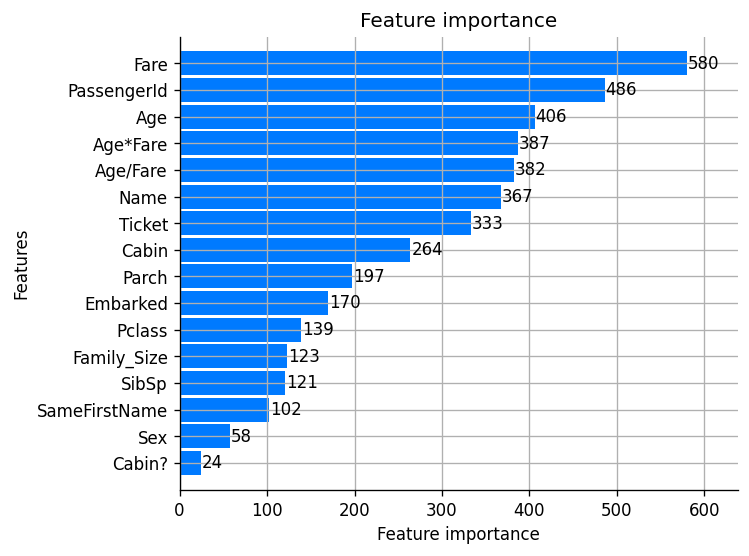

In [190]:
plt.rcParams["figure.figsize"] = (6, 5)
lightgbm.plot_importance(lgbm_wrapper,max_num_features = 16,height=.9)

<a id="base_model_tree"></a>
### (2) Base Model - Decision Tree
- Let's create Base Model
- Model Evaluation is [Accuracy](https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation)
    + If you want to know more, please see https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification

In [ ]:
from sklearn.metrics import accuracy_score
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

- Let's evaluate of base model using validation set
- AUC & Accurarcy are measured at this moment. 

In [ ]:


tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(X_train, y_train)
predictions = tree_model.predict_proba(X_val)
AUC = roc_auc_score(y_val, predictions[:,1])
ACC = acc_score(y_val, predictions[:,1])
print("Model AUC:", AUC)
print("Model Accurarcy:", ACC)
print("\n")

fpr, tpr, _ = roc_curve(y_val, predictions[:,1])

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(fpr, tpr)
ax.text(x = 0.3, 
        y = 0.4, 
        s = "Model AUC is {}\n\nModel Accuracy is {}".format(np.round(AUC, 2), np.round(ACC, 2)), 
        fontsize=16, bbox=dict(facecolor='gray', alpha=0.3))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC curve')

plt.show()

- Good, great. 
- Now, we finally submit file to competition. 
- `.5` Threshold could be different, depending upon your assumption. 
    + If you are not familar with the concept Threshold, then please read this article. https://developers.google.com/machine-learning/crash-course/classification/thresholding

In [ ]:
final_preds = tree_model.predict(test_data)
binarizer = np.vectorize(lambda x: 1 if x >= .5 else 0)
prediction_binarized = binarizer(final_preds)
submission = pd.concat([sample_submission,pd.DataFrame(prediction_binarized)], axis=1).drop(columns=['Survived'])
submission.columns = ['PassengerId', 'Survived']
submission.to_csv('tree_base_submission.csv', index=False)

<a id="helper_class"></a>
### (3) Create Helper Class and Submission Function
- we need to create helper class with common tasks such as model, train, predict, fit, feature_importance, and even ROC Curve Graph
- 


In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from matplotlib import pyplot as plt

SEED = 0 # for Reproducibility

# class 
class sk_helper(object):
    def __init__(self, model, seed = 0, params={}):
        params['random_state'] = seed
        self.model = model(**params)
        self.model_name = str(model).split(".")[-1][:-2]
        
    # train
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        
    # predict
    def predict(self, y_val):
        return self.model.predict(y_val)
    
    # inner fit
    def fit(self, x, y):
        return self.model.fit(x, y)
    
    # feature importance
    def feature_importances(self, X_train, y_train):
        return self.model.fit(X_train, y_train).feature_importances_
        
    # roc_curve
    def roc_curve_graph(self, X_train, y_train, X_val, y_val):
        self.model.fit(X_train, y_train)
        
        print("model_name:", self.model_name)
        model_name = self.model_name
        preds_proba = self.model.predict_proba(X_val)
        preds = (preds_proba[:, 1] > 0.5).astype(int)
        auc = roc_auc_score(y_val, preds_proba[:, 1])
        acc = accuracy_score(y_val, preds)
        confusion = confusion_matrix(y_val, preds)
        print('Confusion Matrix')
        print(confusion)
        print("Model AUC: {0:.3f}, Model Accuracy: {1:.3f}\n".format(auc, acc))
        fpr, tpr, _ = roc_curve(y_val, predictions[:,1])
        fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(fpr, tpr)
        ax.text(x = 0.3, 
                y = 0.4, 
                s = "Model AUC is {}\n\nModel Accuracy is {}".format(np.round(auc, 2), np.round(acc, 2)), 
                fontsize=16, bbox=dict(facecolor='gray', alpha=0.3))
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC curve of {}'.format(model_name), fontsize=16)

        plt.show()

- Now, Let's test if this works or not

<a id="DecisionTreeClassifier"></a>
#### (A) DecisionTreeClassifier
- This is DecisionTreeClassifier Model from [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

In [ ]:
%%time
tree_params = {'max_depth': 6}

tree_model = sk_helper(model=DecisionTreeClassifier, seed=SEED, params=tree_params)
tree_model.roc_curve_graph(X_train, y_train, X_val, y_val)

<a id="RandomForestClassifier"></a>
#### (B) RandomForestClassifier
- This is RandomForestClassifier Model from [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 1
}

rf_model = sk_helper(model=RandomForestClassifier, seed=SEED, params=rf_params)
rf_model.roc_curve_graph(X_train, y_train, X_val, y_val)

<a id="lightgbm"></a>
#### (C) LightGBM
- Let's implement LightGBM with best parameters. You can found it here: https://www.kaggle.com/jmargni/tps-apr-2021-lightgbm-optuna

In [ ]:
%%time

import lightgbm
from lightgbm import LGBMClassifier
print(lightgbm.__version__)
lgb_params = {
    'metric': 'auc',
    'n_estimators': 10000,
    'objective': 'binary',
}

lgb_model = sk_helper(model=LGBMClassifier, seed=SEED, params=lgb_params)
lgb_model.roc_curve_graph(X_train, y_train, X_val, y_val)

<a id="feature_importance"></a>
#### (D) Feature Importance 
- Let's draw graph feature importance plot

In [ ]:
tree_features = tree_model.feature_importances(X_train, y_train)
rf_features = rf_model.feature_importances(X_train, y_train)
lgb_features = lgb_model.feature_importances(X_train, y_train)

In [ ]:
cols = X.columns.values
feature_df = pd.DataFrame({'features': cols, 
                          'Decision Tree': tree_features, 
                          'RandomForest': rf_features, 
                          'LightGBM': lgb_features})

feature_df

In [ ]:
%matplotlib inline

import seaborn as sb
import matplotlib.pyplot as plt

width = 0.3
x = np.arange(0, len(feature_df.index))

## ax[0] graph
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16, 16)) # Option sharex=True
ax[0].bar(x - width/2, feature_df['Decision Tree'], color = "#0095FF", width = width)
ax[0].bar(x + width/2, feature_df['RandomForest'], color = "#E6C0B1", width = width)
ax[0].set_xticks(x)
ax[0].set_xticklabels(feature_df['features'], rotation=90)

## ax[0] legend
colors = {'Decision Tree':'#0095FF', 'RandomForest':'#E6C0B1'} 
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

ax[0].legend(handles, labels, bbox_to_anchor = (0.95, 0.95))
ax[0].set_title("Feature Importance between Decision Tree and RandomForest", fontsize=20)

## ax[1] graph
ax[1].bar(x, feature_df['LightGBM'], color = "#60F09E")
ax[1].set_xticks(x)
ax[1].set_xticklabels(feature_df['features'], rotation=90)
ax[1].set_title("Feature Importance of LightGBM", fontsize=20)

## plt manage
## plt.xticks(x, feature_df['features'], rotation=90)
plt.tight_layout()
plt.show()

- Each algorithm provides different feature important values. 
    + If you want to know this concept further, please read this article: [How to Calculate Feature Importance With Python](https://machinelearningmastery.com/calculate-feature-importance-with-python/)
- The main goal here is to improve a predictive model, deleting some features. For example, feature SisSp and Parch in both algorithm are not quite important. So, At this moment, we can delete them.
    + This code will be worked with feature engineering section. 


### 

<a id="submission"></a>
#### (E) Submission
- Now, we create submission function. 

In [ ]:
import numpy as np
from datetime import datetime

version = datetime.now().strftime("%d-%m-%Y %H-%M-%S")

def final_submission(model, data, version):
    final_preds = model.predict(data)
    binarizer = np.vectorize(lambda x: 1 if x >= .5 else 0)
    prediction_binarized = binarizer(final_preds)
    submission = pd.concat([sample_submission,pd.DataFrame(prediction_binarized)], axis=1).drop(columns=['Survived'])
    submission.columns = ['PassengerId', 'Survived']
    submission.to_csv('Sklearn of Submit Date {} Submission.csv'.format(version), index=False)
    
final_submission(lgb_model, test_data, version)

- Now, We will move on `PyCaret` Framework. 

<a id='pycaret'></a>
## PyCaret
![](https://miro.medium.com/max/2048/1*Cku5-rqmqSIuhUyFkIAdIA.png)

- PyCaret.. Caret in R?
    + My 1st reaction on this.. when got heard .. was "is it copy of [caret](https://cran.r-project.org/web/packages/caret/vignettes/caret.html) package in R?"
    
- Let's look at this framework. 


<a id="intro"></a>
### (1) Intro
- URL: https://pycaret.org/about/
> It's an open source low-code machine learning library that aims to reduce cycle time from hypothesis to insights. 

- Point 1. Simple and Easy to use
> All the operations performed in PyCaret are automatically stored in a custom `Pipeline` that is fully orchestrated for `deployment`. 
- Point 2. Python Wrapper
> Around several machine learning libraries and frameworks such as scikit-learn, XGBoost, Microsoft LightGBM, spaCy and many more. 
- Point 3. Train Multiple Models 
> It trains multiple models SIMULTANEOUSLY.. (interesting!) and outputs a table comparing performaces of each model you developed. 
- Point 4. [PyCaret on GPU](https://pycaret.readthedocs.io/en/latest/installation.html)
> `PyCaret >= 2.2` provides the option to use GPU for select model training and hyperparameter tuning. There is no change in the use of the API, however, in some cases, additional libraries have to be installed as they are not installed with the default slim version or the full version. The following estimators can be trained on GPU.

<a id="pycaret_tutorials"></a>
### (2) PyCaret Tutorials 
- If you want to learn some basic tutorials, then please visit here: https://pycaret.readthedocs.io/en/latest/tutorials.html
     + I will skip out introducing some basic codes here. 

<a id="base_model"></a>
### (3) Base Model
- Unfortunately, if you want to use this framework, then you should install it with following command. 
> !pip install pycaret

- It will take a few minutes.

- We will downgrade it this since we are going to use PyCaret. Some issues are reported.
    + https://github.com/pycaret/pycaret/issues/1140

In [ ]:
# !pip uninstall scikit-learn -y
!pip install pycaret==2.2.3

- Let's check version

In [ ]:
# check version
from pycaret.utils import version
import sklearn
print("pycaret version:", version())
print("sklearn version:", sklearn.__version__)

<a id="initialize_setup"></a>
#### (A) Initialize Setup
- Before you train, you need to setup with following code. 
- Here, We need to combine two dataframe, X and y and stored it as train_data


In [ ]:
all_df_pycaret = pd.concat([X, y], axis=1)
all_df_pycaret['Survived'] = all_df_pycaret['Survived'].astype('int64')
all_df_pycaret.info()

- This code is simple but very powerful. 
- If you want to study more setting up more options such as Data Preparation, Scale and Transformation, and Feature Engineering, Feature Selection. Then please visit here: https://pycaret.org/train-test-split/


In [ ]:
from pycaret.classification import *

setup(data = all_df_pycaret, 
      target = 'Survived', 
      fold = 3,
      silent = True
     )

<a id="compare_models"></a>
#### (B) Comparing All Models
- This is starting point to recommend a model, evaluating performaces of all models when the setup is completed. 
- This function trains all models in the model library and scores them using stratified cross validation for metric evaluation.

In [ ]:
%%time

best_model = compare_models(sort = 'Accuracy', n_select = 3)

In [ ]:
print(best_model)

- To me, the best model is `Gradient Boosting Classifier`
- So, We will create GBC model in this tutorial. 

<a id="create_pycaret_model"></a>
#### (C) Create Model
- This function creates a model and scores it using Stratified Cross Validation.The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa and MCC by fold (default = 10 Fold). This function returns a trained model object. 
- You can create different models here. 
    + Examples: https://pycaret.org/classification/

```python
# train logistic regression model
lr = create_model('lr') #lr is the id of the model
# check the model library to see all models
models()
# train rf model using 5 fold CV
rf = create_model('rf', fold = 5)
# train svm model without CV
svm = create_model('svm', cross_validation = False)
# train xgboost model with max_depth = 10
xgboost = create_model('xgboost', max_depth = 10)
# train xgboost model on gpu
xgboost_gpu = create_model('xgboost', tree_method = 'gpu_hist', gpu_id = 0) #0 is gpu-id
# train multiple lightgbm models with n learning_rate<br>import numpy as np
lgbms = [create_model('lightgbm', learning_rate = i) for i in np.arange(0.1,1,0.1)]
# train custom model
from gplearn.genetic import SymbolicClassifier
symclf = SymbolicClassifier(generation = 50)
sc = create_model(symclf)
```

In [ ]:
%%time
gbc_model = create_model('gbc')

<a id="tune_pycaret_model"></a>
#### (D) Tune Model
- This function tunes the hyperparameters of a model and scores it using Stratified Cross Validation. The output prints a score grid that shows Accuracy, AUC, Recall Precision, F1, Kappa, and MCCby fold (by default = 10 Folds). This function returns a trained model object.
    + Examples: https://pycaret.org/classification/#tune-model
    
```python
# train a decision tree model with default parameters
dt = create_model('dt')

# tune hyperparameters of decision tree
tuned_dt = tune_model(dt)

# tune hyperparameters with increased n_iter
tuned_dt = tune_model(dt, n_iter = 50)

# tune hyperparameters to optimize AUC
tuned_dt = tune_model(dt, optimize = 'AUC') #default is 'Accuracy'

# tune hyperparameters with custom_grid
params = {"max_depth": np.random.randint(1, (len(data.columns)*.85),20),
          "max_features": np.random.randint(1, len(data.columns),20),
          "min_samples_leaf": [2,3,4,5,6],
          "criterion": ["gini", "entropy"]
          }

tuned_dt_custom = tune_model(dt, custom_grid = params)

# tune multiple models dynamically
top3 = compare_models(n_select = 3)
tuned_top3 = [tune_model(i) for i in top3]
```

In [ ]:
%%time
tuned_gbc = tune_model(gbc_model, n_iter = 50)

<a id = "plot_pycaret_model"></a>
#### (E) Plot Model
- This function takes a trained model object and returns a plot based on the test / hold-out set. The process may require the model to be re-trained in certain cases. See list of plots supported below. Model must be created using create_model() or tune_model().
    + Examples: https://pycaret.org/classification/#plot-model

```python
#create a model
lr = create_model('lr')
#plot a model
plot_model(lr)
```

- Many options are avaiable. 

In [ ]:
plot_model(tuned_gbc, plot = 'confusion_matrix')

In [ ]:
plot_model(tuned_gbc, plot = 'feature_all')

In [ ]:
plot_model(tuned_gbc, plot = 'auc')

<a id="preds_submissions"></a>
#### (F) Predictions and Submissions
- Now, it's time to predict and submit it. 


In [ ]:
predictions = predict_model(tuned_gbc, data = test_data)
predictions.info()

In [ ]:
submission = pd.read_csv(BASE_DIR + 'sample_submission.csv')
submission['Survived'] = predictions['Label']
submission.to_csv('PyCaret Submission.csv', index=False)
submission.head()

- Finally Done. I will review the framework later. 

#### 